# Models Evaluation

In this notebook, we compare the quality, diversity, and FID of images generated by GAN models trained with different losses such as *Kullback Leibler*, *Reverse Kullback Liebler*, *Jensen Shannon* and *Binary Cross Entropy*.

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import numpy as np
from typing import Dict
import torch

from importlib import reload

from src.gan import Generator
from src.classifier import Classifier
import src.external.prd_score as prd

reload(prd)
from src.loading import get_mnist_images_scaled
from src.device import setup_device
from src.metrics import MetricsCalculator

In [60]:
NUM_IMAGES_TO_EVAL = 10000
PRD_NUM_CLUSTERS = 50  # for PRD curves (number of bins in the histogram)
PR_NEAREST_K = 3  # for precision and recall
PRD_NUM_ANGLES = 1000
BATCH_SIZE = 128
device = setup_device()

Using device: CPU


In [26]:
COLORS = ["C0", "C1", "C2", "C3"]  # Blue, Orange, Green, Red
MARKERS = ["o", "s", "D", "^"]

In [27]:
classifier = Classifier.load("../checkpoints/classifier.pth", device)
generators = {
    "BCE": Generator.load("../checkpoints/BCE_G.pth", device),
    "KL": Generator.load("../checkpoints/KL_G.pth", device),
    "RKL": Generator.load("../checkpoints/RKL_G.pth", device),
    "JS": Generator.load("../checkpoints/JS_G.pth", device),
}

In [43]:
def compute_prd_data(generators: Dict[str, Generator], classifier: Classifier):

    real_images = get_mnist_images_scaled(NUM_IMAGES_TO_EVAL, device)
    real_embeddings = classifier.extract_features(real_images).cpu().detach().numpy()

    all_prd_data = []
    all_names = []
    for gen_name, gen in tqdm(generators.items(), desc="Computing PRD Data"):

        # Extract fake embeddings
        fake_images = gen.sample(NUM_IMAGES_TO_EVAL, BATCH_SIZE, device, latent_std=1.0)
        fake_embeddings = (
            classifier.extract_features(fake_images).cpu().detach().numpy()
        )

        # Compute PRD Data
        prd_data = prd.compute_prd_from_embedding(
            fake_embeddings,
            real_embeddings,
            num_angles=PRD_NUM_ANGLES,
            num_clusters=PRD_NUM_CLUSTERS,
        )

        all_prd_data.append(prd_data)
        all_names.append(gen_name)

    return all_prd_data, all_names

In [44]:
all_prd_data, all_labels = compute_prd_data(generators, classifier)

Computing PRD Data: 100%|██████████| 4/4 [00:31<00:00,  7.90s/it]


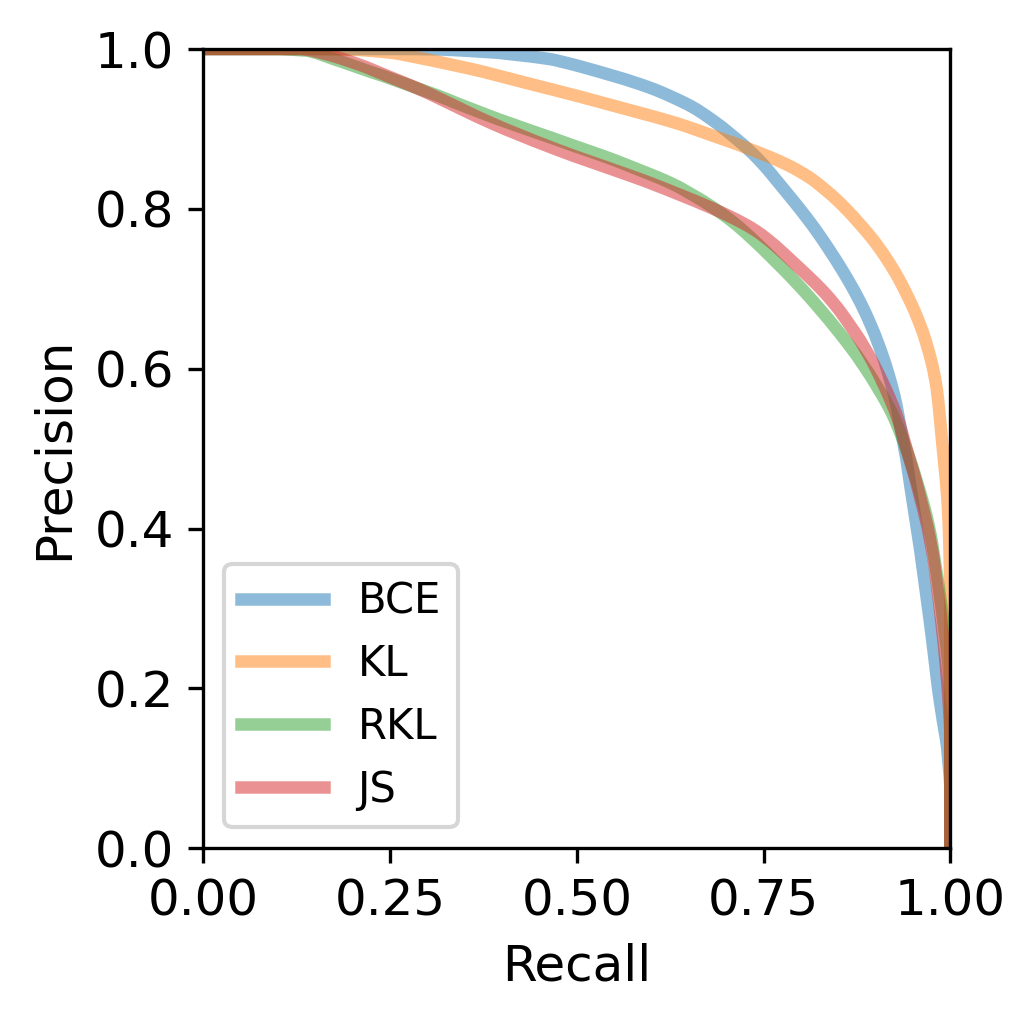

In [45]:
prd.plot(all_prd_data, all_labels)

Saved Precision/Recall plot to precision_recall_history.png
Saved FID plot to fid_history.png


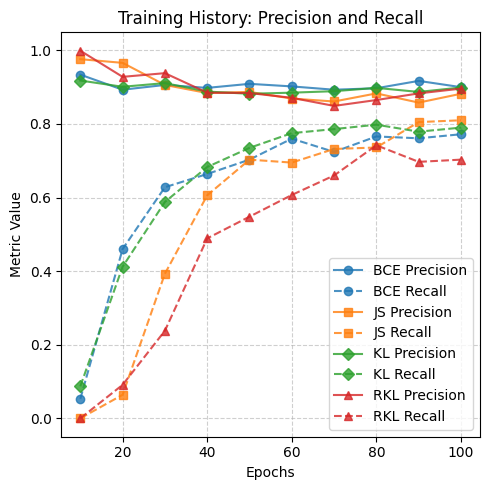

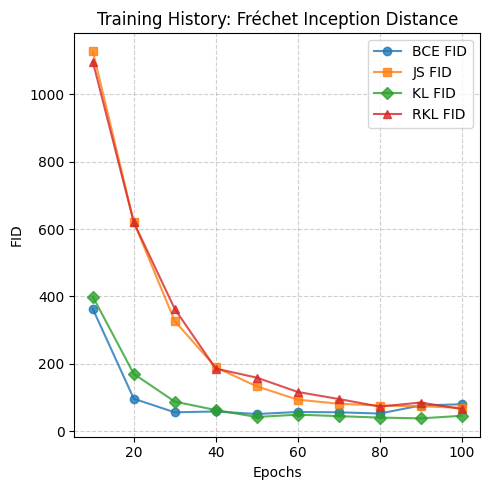

In [ ]:
training_histories = {
    "BCE": torch.load("../histories/BCE_training_history.pth", weights_only=False),
    "JS": torch.load("../histories/JS_training_history.pth", weights_only=False),
    "KL": torch.load("../histories/KL_training_history.pth", weights_only=False),
    "RKL": torch.load("../histories/RKL_training_history.pth", weights_only=False),
}

# --- Plot 1: Precision and Recall ---

fig1, ax1 = plt.subplots(figsize=(5, 5))


for i, (model_name, history) in enumerate(training_histories.items()):
    color = COLORS[i % len(COLORS)]
    marker = MARKERS[i % len(MARKERS)]
    epochs = history["eval_epochs"]

    # Keep only epochs multiple of 10 for clarity
    epochs = [e for e in epochs if e % 10 == 0]
    history["precision"] = [
        p for e, p in zip(history["eval_epochs"], history["precision"]) if e % 10 == 0
    ]
    history["recall"] = [
        r for e, r in zip(history["eval_epochs"], history["recall"]) if e % 10 == 0
    ]

    # Plot Precision (solid line)
    ax1.plot(
        epochs,
        history["precision"],
        marker=marker,
        linestyle="-",
        color=color,
        label=f"{model_name} Precision",
        alpha=0.8,
    )

    # Plot Recall (dashed line)
    ax1.plot(
        epochs,
        history["recall"],
        marker=marker,
        linestyle="--",
        color=color,
        label=f"{model_name} Recall",
        alpha=0.8,
    )

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Metric Value")
ax1.set_title("Training History: Precision and Recall")
ax1.legend(loc="best")
ax1.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("precision_recall_history.png")

print("Saved Precision/Recall plot to precision_recall_history.png")


# --- Plot 2: FID (Fréchet Inception Distance) ---

fig2, ax2 = plt.subplots(figsize=(5, 5))

for i, (model_name, history) in enumerate(training_histories.items()):
    color = COLORS[i % len(COLORS)]
    marker = MARKERS[i % len(MARKERS)]
    epochs = history["eval_epochs"]

    # Keep only epochs multiple of 10 for clarity
    epochs = [e for e in epochs if e % 10 == 0]
    history["fid"] = [
        f for e, f in zip(history["eval_epochs"], history["fid"]) if e % 10 == 0
    ]

    # Plot FID
    ax2.plot(
        epochs,
        history["fid"],
        marker=marker,
        linestyle="-",
        color=color,
        label=f"{model_name} FID",
        alpha=0.8,
    )

ax2.set_xlabel("Epochs")
ax2.set_ylabel("FID")
ax2.set_title("Training History: Fréchet Inception Distance")
ax2.legend(loc="best")
ax2.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("fid_history.png")

print("Saved FID plot to fid_history.png")

In [61]:
metrics_calculator = MetricsCalculator(
    classifier, device, BATCH_SIZE, nearest_k=PR_NEAREST_K
)

real_images = get_mnist_images_scaled(NUM_IMAGES_TO_EVAL, device)

latent_stds = np.logspace(np.log10(0.5), np.log10(2.0), num=11)


all_metrics = {}
for name, generator in generators.items():

    all_metrics[name] = {}

    for latent_std in latent_stds:

        fake_images = generator.sample(
            NUM_IMAGES_TO_EVAL, BATCH_SIZE, device, latent_std=latent_std
        )
        metrics = metrics_calculator.calculate_metrics(real_images, fake_images)

        all_metrics[name][latent_std] = metrics.copy()

        print(
            f"{name} with latent std of {latent_std:.3f}: P={metrics['precision']:.4f}, R={metrics['recall']:.4f}, FID={metrics['fid']:.2f}"
        )

Num real: 10000 Num fake: 10000
BCE with latent std of 0.500: P=0.9378, R=0.3334, FID=749.83
Num real: 10000 Num fake: 10000
BCE with latent std of 0.574: P=0.9321, R=0.4096, FID=520.09
Num real: 10000 Num fake: 10000
BCE with latent std of 0.660: P=0.9290, R=0.4794, FID=337.50
Num real: 10000 Num fake: 10000
BCE with latent std of 0.758: P=0.9144, R=0.5561, FID=194.35
Num real: 10000 Num fake: 10000
BCE with latent std of 0.871: P=0.9015, R=0.6210, FID=106.59
Num real: 10000 Num fake: 10000
BCE with latent std of 1.000: P=0.8956, R=0.6460, FID=63.71
Num real: 10000 Num fake: 10000
BCE with latent std of 1.149: P=0.8709, R=0.6780, FID=51.72
Num real: 10000 Num fake: 10000
BCE with latent std of 1.320: P=0.8519, R=0.6878, FID=61.97
Num real: 10000 Num fake: 10000
BCE with latent std of 1.516: P=0.8310, R=0.6611, FID=94.10
Num real: 10000 Num fake: 10000
BCE with latent std of 1.741: P=0.8065, R=0.6731, FID=140.90
Num real: 10000 Num fake: 10000
BCE with latent std of 2.000: P=0.7773, R=

In [62]:
MARKERS = [
    "o",  # Circle
    "s",  # Square
    "^",  # Triangle
    "D",  # Diamond
    "p",  # Pentagon
    "*",  # Star
]
COLORS = ["C0", "C1", "C2", "C3", "C4", "C5"]

In [63]:
def plot_pr_trajectories(
    all_metrics: Dict[str, Dict[float, Dict[str, float]]],
    title: str = "Precision/Recall Trajectories",
):
    """
    Plots Precision (Y) vs. Recall (X) with lines connecting points for the same model
    and uses color mapping to represent the FID score.
    """

    # 2. Setup Plotting Area
    fig, ax = plt.subplots(figsize=(5, 5))

    # 3. Plotting Loops

    for index, (name, model_data) in enumerate(all_metrics.items()):
        # Sort data by latent_std value (which are the dictionary keys)
        sorted_stds = sorted(model_data.keys())

        # Extract P, R, F lists in the correct sequence for plotting the line
        precisions = [model_data[std]["precision"] for std in sorted_stds]
        recalls = [model_data[std]["recall"] for std in sorted_stds]

        # --- A. Plot the Line (The Trajectory) ---
        ax.plot(
            recalls,
            precisions,
            linewidth=2.0,
            color=COLORS[index % len(COLORS)],
            label=f"{name} Model",
        )

    start_points = []
    mid_points = []
    end_points = []
    for name, model_data in all_metrics.items():
        sorted_stds = sorted(model_data.keys())
        start_points.append(
            (
                model_data[sorted_stds[0]]["recall"],
                model_data[sorted_stds[0]]["precision"],
            )
        )
        mid_points.append(
            (
                model_data[sorted_stds[len(sorted_stds) // 2]]["recall"],
                model_data[sorted_stds[len(sorted_stds) // 2]]["precision"],
            )
        )
        end_points.append(
            (
                model_data[sorted_stds[-1]]["recall"],
                model_data[sorted_stds[-1]]["precision"],
            )
        )

    ax.scatter(
        [p[0] for p in start_points],
        [p[1] for p in start_points],
        c="green",
        s=100,
        edgecolors="black",
        linewidth=1.0,
        marker="X",
        label=r"$\sigma =$" + f"{latent_stds[0]:.2f}",
        zorder=4,
    )

    ax.scatter(
        [p[0] for p in mid_points],
        [p[1] for p in mid_points],
        c="blue",
        s=100,
        edgecolors="black",
        linewidth=1.0,
        marker="o",
        label=r"$\sigma =$" + f"{latent_stds[len(latent_stds) // 2]:.2f}",
        zorder=4,
    )

    ax.scatter(
        [p[0] for p in end_points],
        [p[1] for p in end_points],
        c="red",
        s=100,
        edgecolors="black",
        linewidth=1.0,
        marker="P",
        label=r"$\sigma =$" + f"{latent_stds[-1]:.2f}",
        zorder=4,
    )

    # 4. Final Plot Customization
    ax.set_xlabel("Recall (Diversity)", fontsize=12)
    ax.set_ylabel("Precision (Quality)", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

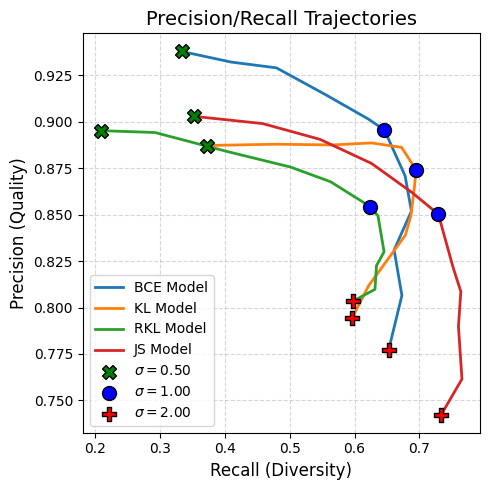

In [ ]:
plot_pr_trajectories(all_metrics)

## Soft truncation on KL

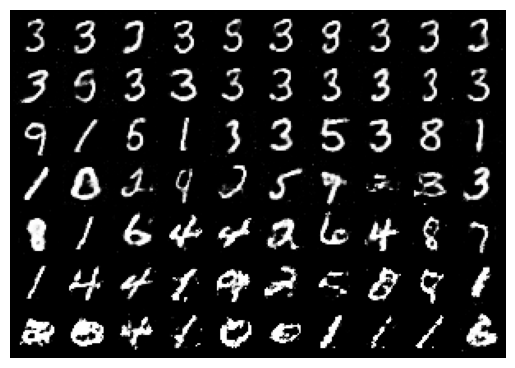

In [82]:
from src.grids import create_truncation_grid_tensor

latent_stds = np.logspace(np.log10(1 / 4), np.log10(4), num=7)
num_samples_per_std = 10

gene = Generator.load("../checkpoints/KL_G.pth", device)
grid = create_truncation_grid_tensor(
    generator=gene,
    latent_std_values=latent_stds,
    num_samples_per_std=num_samples_per_std,
    device=device,
)
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()

Latent Std: 0.250
Latent Std: 0.397
Latent Std: 0.630
Latent Std: 1.000
Latent Std: 1.587
Latent Std: 2.520
Latent Std: 4.000


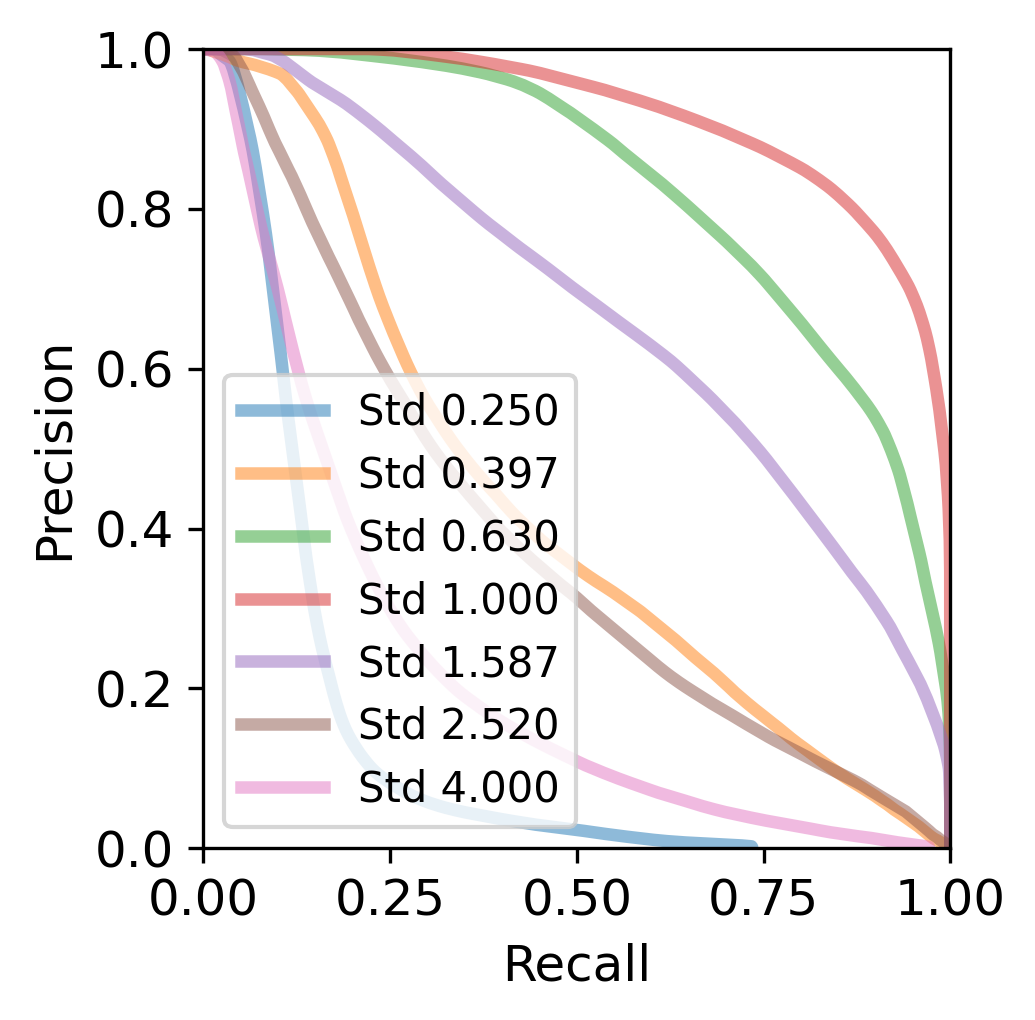

In [83]:
real_images = get_mnist_images_scaled(NUM_IMAGES_TO_EVAL, device)
real_embeddings = classifier.extract_features(real_images).cpu().detach().numpy()

all_prd_data = []
for std in latent_stds:
    print(f"Latent Std: {std:.3f}")
    fake_images = gene.sample(NUM_IMAGES_TO_EVAL, BATCH_SIZE, device, latent_std=std)
    fake_embeddings = classifier.extract_features(fake_images).cpu().detach().numpy()
    prd_data = prd.compute_prd_from_embedding(
        fake_embeddings,
        real_embeddings,
        num_angles=PRD_NUM_ANGLES,
        num_clusters=PRD_NUM_CLUSTERS,
    )
    all_prd_data.append(prd_data)

prd.plot(all_prd_data, [f"Std {std:.3f}" for std in latent_stds])